# Optimizar gastos de marketing
Descripción del proyecto
Showz, es una empresa de venta de entradas de eventos. El objetivo es ayudar a optimizar los gastos de marketing. 

Se tiene:
- Registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018;
- Un archivo con los pedidos en este periodo;
- Estadísticas de gastos de marketing.

Se va a investigar: 
- Cómo los clientes usan el servicio;
- Cuándo empiezan a comprar;
- Cuánto dinero aporta cada cliente a la compañía;
- Cuándo los ingresos cubren el costo de adquisición de los clientes.

Descripción de los datos
La tabla visits (registros del servidor con datos sobre las visitas al sitio web):
- Uid: identificador único del usuario.
- Device: dispositivo del usuario.
- Start Ts: fecha y hora de inicio de la sesión.
- End Ts: fecha y hora de término de la sesión.
- Source Id: identificador de la fuente de anuncios de la que proviene el usuario.

La tabla orders (datos sobre pedidos):
- Uid: identificador único del usuario que realiza un pedido.
- Buy Ts: fecha y hora del pedido. Revenue: el ingreso de Showz por el pedido.

La tabla costs (datos sobre gastos de marketing):
- source_id: identificador de la fuente de anuncios.
- dt: fecha.
- costs: gastos en esta fuente de anuncios en este día.

Todas las fechas de esta tabla están en formato AAAA-MM-DD.

Etapas del proyecto:
1. Acceder a los datos y prepáralos para el análisis.
2. Hacer informes y calcular métricas. 

## Acceder a los datos y prepáralos para el análisis.

In [1]:
#Importar las librerias que se van a utilizar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Acceder a los datos
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

### Visitas

In [3]:
#Revisar el archivo
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
#Información general
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Aparentemente no hay valores ausentes, los nombres de las columnas no están con el formato snake_case y es necesario cambiar el tipo de datos de los id y las fechas.

In [5]:
#Cambiar el nombre de las columnas para que tengan el formato snake_case
new_col_names = []

for old_names in visits.columns:
    name_lowered = old_names.lower()
    name_stripped = name_lowered.strip()
    new_col_names.append(name_stripped)
    
visits.columns = new_col_names

columns_new = {'end ts': 'end_ts', 'source id':'source_id', 'start ts':'start_ts'}

visits.rename(columns = columns_new, inplace=True)

visits.columns 

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [6]:
#Cambiar 'end_ts' y 'start_ts' a tipo de datos de fechas
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')

#'source_id' y 'uid' no son números para hacer calculos, así que se cambian a tipo object
visits['source_id'] = visits['source_id'].astype('object')
visits['uid'] = visits['uid'].astype('object')

visits.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  object        
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 13.7+ MB


In [7]:
#Verificar si hay valores duplicados
visits.duplicated().sum()

0

In [8]:
#Verificar si hay valores ausentes
visits.isna().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

### Pedidos

In [9]:
#Revisar el archivo 
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [10]:
#Información general
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Aparentemente no hay valores ausentes, los nombres de las columnas no están con el formato snake_case y es necesario cambiar el tipo de datos de los id y las fechas.

In [11]:
#Cambiar el nombre de las columnas para que tengan el formato snake_case
new_col_names = []

for old_names in orders.columns:
    name_lowered = old_names.lower()
    name_stripped = name_lowered.strip()
    new_col_names.append(name_stripped)
    
orders.columns = new_col_names

columns_new = {'buy ts':'buy_ts'}

orders.rename(columns = columns_new, inplace=True)

orders.columns 

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [12]:
#Cambiar 'buy_ts' a tipo de datos de fechas
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d %H:%M:%S')

#'source_id' y 'uid' no son números para hacer cálculos, así que se cambian a tipo object
orders['uid'] = orders['uid'].astype('object')

orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


In [13]:
#Verificar si hay valores duplicados
orders.duplicated().sum()

0

In [14]:
#Verificar si hay valores ausentes
orders.isna().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

### Costos

In [15]:
#Revisar el archivo 
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [16]:
#Información general 
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Aparentemente no hay valores ausentes, los nombres de las columnas en formato snake_case y es necesario cambiar el tipo de datos de los id y las fechas.

In [18]:
#Cambiar 'dt' a tipo de datos de fechas
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')

#'source_id' no son némeros para hacer cálculos, así que se cambian a tipo object
costs['source_id'] = costs['source_id'].astype('object')

costs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   object        
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.7+ KB


In [19]:
#Verificar si hay valores duplicados
costs.duplicated().sum()

0

In [20]:
#Verificar si hay valores ausentes
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

## Hacer informes y calcular métricas

### Visitas

#### ¿Cuántas personas lo usan cada día, semana y mes?

In [21]:
#Crear columnas separadas para los valores de día, semana, mes y año
visits['day'] = visits['start_ts'].dt.to_period('D').dt.start_time
visits['week'] = visits['start_ts'].dt.to_period('W').dt.start_time
visits['month'] = visits['start_ts'].dt.to_period('M').dt.start_time

#Calcular el número de usuarios diarios
dau_total = visits.groupby('day').agg({'uid': 'nunique'}).mean()

#Calcular el número de usuarios por semana
wau_total = visits.groupby('week').agg({'uid': 'nunique'}).mean()

#Calcular el número de usuarios por semana
mau_total = visits.groupby('month').agg({'uid': 'nunique'}).mean()

print('Usuarios por días:', int(dau_total))
print('Usuarios por semana:', int(wau_total))
print('Usuarios por mes:', int(mau_total))

Usuarios por días: 907
Usuarios por semana: 5716
Usuarios por mes: 23228


#### ¿Cuántas sesiones hay por día?

In [24]:
#Calcular las sesiones por días
sessions_per_day = visits.groupby('day').agg({'uid':['count']})
sessions_per_day.columns = ['n_sessions']
sessions_per_day.head()

,n_sessions
day,
2017-06-01,664
2017-06-02,658
2017-06-03,477
2017-06-04,510
2017-06-05,893


#### ¿Cuál es la duración de cada sesión?

In [25]:
#Crear una columna para calcular la duración de la sesión por segundos
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,0


<AxesSubplot:>

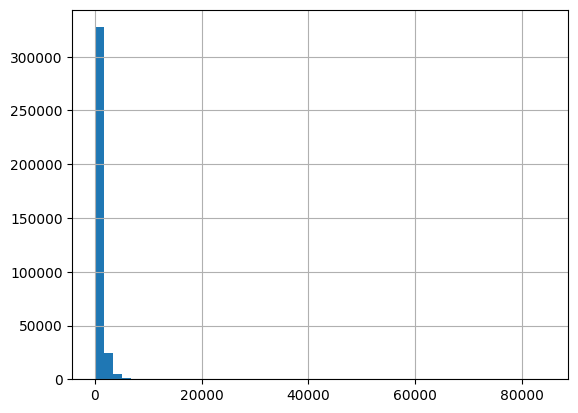

In [26]:
#Verificar la distribución de la duración para determinar si es confiable utilizar la media
visits['session_duration_sec'].hist(bins=50)

La distribución de la duración de las sesiones no es normal, por lo que en vez de utilizar la media para calcular la duración promedio, voy a utilizar la moda.

In [27]:
#Calcular la duración media de la sesión
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

La sesión promedio de los usuarios es de 60 segundos, es decir 1 minuto. Probablemente esto no sea tiempo suficiente para comprar entradas de eventos.

#### ¿Con qué frecuencia los usuarios regresan?

In [28]:
#Encontrar la primera visita de cada cliente
first_visits = visits.groupby('uid')['start_ts'].min()

#Cambiar el nombre de la columna
first_visits.name = 'first_visit'

#Unir el DataFrame visits con la serie first_visit_dates
visits = visits.join(first_visits, on = 'uid')

#Separar los meses de las columnas first_visit_date
visits['first_month'] = visits['first_visit'].dt.to_period('M').dt.start_time

#Agrupar por cohorte 
visits_by_cohort = visits.groupby(['month', 'first_month']).agg({'uid': 'nunique'})

#Crear una tabla dinámica para poder encontrar los valores
visits_pivot = visits_by_cohort.pivot_table(index = 'first_month',
                                            columns = 'month',
                                            values = 'uid',
                                            aggfunc = 'sum')
visits_pivot

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


En todas las cohortes el comportamiento es el mismo, mes a mes disminuye la cantidad de visitas a la página.

### Ventas

#### ¿Cuándo empieza la gente a comprar?

In [30]:
#Encontrar la primera compra de cada cliente
first_order = orders.groupby('uid')['buy_ts'].min()

#Cambiar el nombre de la columna
first_order.name = 'first_order'

#Unir el DataFrame orders con la serie first_visit_dates
orders = orders.join(first_order, on = 'uid')

#Unir el las primeras ordenes con las primeras visitas
first_purchase = pd.merge(orders[['first_order', 'uid']], visits[['first_visit', 'uid', 'source_id']], on = 'uid')

#Sacar la diferencia en horas desde el primer inicio de sesión y la primera compra
first_purchase['time_to_order'] = (first_purchase['first_order'] - first_purchase['first_visit'])/np.timedelta64(1, 'h') 

In [31]:
#Crear una función para categorizar el tiempo de compra por días
def conversion(days):
    if days <= 7:
        return 'Conversion 0-7d'
    elif days <= 14:
        return 'Conversion 8-14d'
    elif days <= 30:
        return 'Conversion 15-30d'
    elif days <= 60:
        return 'Conversion 31-60d'
    elif days <= 90:
        return 'Conversion 61-90d'
    elif days <= 180:
        return 'Conversion 91-180d'
    elif days <= 364:
        return 'Conversion 181-364d'
    else:
        return 'Conversion >365d'
    
#Aplicar la función para crear una nueva columna de categorías
first_purchase['conversion'] = first_purchase['time_to_order'].apply(conversion)

#Sacar la moda para encontrar cual de las conversiones se repite más
first_purchase['conversion'].mode()

0    Conversion 0-7d
dtype: object

La mayoría de usuarios hacen su primera compra en la primera semana después de iniciar sesión por primera vez.

#### ¿Cuántos pedidos hacen durante un período de tiempo dado?

In [32]:
#Crear una columna para los meses
orders['month'] = orders['buy_ts'].dt.to_period('M').dt.start_time

#Agrupar para sacar la cantidad de pedidos por mes
orders_per_month = orders.groupby('month').agg({'uid':'count'})
orders_per_month

,uid
month,
2017-06-01,2354
2017-07-01,2363
2017-08-01,1807
2017-09-01,3387
2017-10-01,5679
2017-11-01,5659
2017-12-01,6218
2018-01-01,4721
2018-02-01,5281


Los pedidos varían mucho de mes a mes, esto puede darse porque no todos los meses hay la misma cantidad de eventos. Por otro lado, en junio de 2018 solo hubo 1 compra, así que se debe analizar si hubo algún problema con la plataforma o por qué se dio esto.

#### ¿Cuál es el tamaño promedio de compra?

In [33]:
#Agrupar por compra por usuario para sacar el promedio
orders_revenue_per_month = orders.groupby('uid').agg({'revenue':'sum'})
orders_revenue_per_month

#Sacar el promedio de todos los meses
average_orders = orders_revenue_per_month['revenue'].mean()
average_orders

6.901327930345262

El tamaño promedio de compra, por usuario, en un mes es $6.9.

#### ¿Cuánto dinero traen?

In [34]:
#Unir el DataFrame orders con visits
revenue = visits.merge(orders, on = 'uid')

#Sacar los gastos diarios por fuente de anuncios 
ltv = revenue.groupby(['source_id', 'day'])['revenue'].sum().reset_index()

#Sacar cuantos clientes nuevos se adquieren al día por fuente de anuncios
daily_acquisition = revenue.groupby(['source_id', 'day'])['uid'].nunique().reset_index().rename(columns = {'uid': 'new_users'})

#Sacar el costo diario por cliente
daily_ltv = daily_acquisition.merge(ltv, on = ['day', 'source_id'])
daily_ltv['ltv'] = daily_ltv['revenue'] / daily_ltv['new_users']
daily_ltv.groupby('source_id')['ltv'].mean().reset_index()

,source_id,ltv
0,1,170.899521
1,2,150.591234
2,3,17.079080
3,4,25.468076
4,5,86.811236
5,7,1.220000
6,9,7.549015
7,10,6.218319


Las fuentes de anuncios que más ingresos generan son la #1 y #2, y la que menos ingresos genera es la #7. Se recomienda analizar las fuentes de anuncios #6 y #8, ya que según esto no están generando ingresos.

### Costos

#### ¿Cuánto dinero se gastó?

In [35]:
#Crear columnas separadas para los valores de día
costs['day'] = costs['dt'].dt.to_period('D').dt.start_time

#Sacae los gastos diarios por fuente de anuncios 
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


A lo largo del tiempo, la fuente #3 es en la que más dinero se gasta, más del doble respecto a las otras y las #9 y #10 son las menos costosas.

#### ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

In [36]:
#Sacar los gastos diarios por fuente de anuncios 
daily_costs = costs.groupby(['source_id', 'day'])['costs'].sum().reset_index()

#Sacar el costo diario por cliente
daily_cac = daily_costs.merge(daily_acquisition, on = ['day', 'source_id'])
daily_cac['cac'] = daily_cac['costs'] / daily_cac['new_users']
daily_cac.groupby('source_id')['cac'].mean().reset_index()

,source_id,cac
0,1,1.766852
1,2,2.778808
2,3,8.753990
3,4,3.371557
4,5,4.181618
5,9,2.617818
6,10,3.791316


La fuente de anuncios más costosa es la #3 y la más económica es la #1.

#### ¿Cuán rentables eran las inversiones?

In [37]:
#Unir LTV y CAC para sacar ROMI
daily_romi = daily_ltv.merge(daily_cac, on = 'source_id')
daily_romi['romi'] = (daily_romi['ltv'] / daily_romi['cac']) 
daily_romi.groupby('source_id')['romi'].mean().reset_index()

,source_id,romi
0,1,114.395574
1,2,60.347642
2,3,2.443970
3,4,36.816545
4,5,23.346308
5,9,6.535282
6,10,3.244488


Todas las inversiones en las fuentes de anuncios, están siendo rentables. La más rentable, por mucho, es la #1. Mientras que las #3, #9 y #10 son las menos rentables, sin embargo, ninguna está generando perdidas.

# Conclusión

En todas las cohortes el comportamiento es el mismo, mes a mes disminuye la cantidad de visitas a la página. Sería bueno analizar por qué los usuarios dejan de utilizar la plataforma. 

El tamaño promedio de compra, por usuario, en un mes es $6.9.

Las fuentes de anuncios que más ingresos generan son la #1 y #2, y la que menos ingresos genera es la #7. Se recomienda analizar las fuentes de anuncios #6 y #8, ya que según esto no están generando ingresos.

A lo largo del tiempo, la fuente #3 es en la que más dinero se gasta, más del doble respecto a las otras y las #9 y #10 son las menos costosas.

La fuente de anuncios más costosa es la #3 y la más económica es la #1.

Todas las inversiones en las fuentes de anuncios, están siendo rentables. La más rentable, por mucho, es la #1. Mientras que las #3, #9 y #10 son las menos rentables, sin embargo, ninguna está generando perdidas.

La fuente de anuncios #1 es la más económica y sin embargo es la que más ganancias está generando. Por otro lado la #3 es la más costosa y es la que menos retorno de inversión está generando. Por esto, mi recomendación es invertir más en la fuente de anuncios #1 y analizar la posibilidad de no invertir más en la fuente #3.